In [ ]:
!pip install python-docx pandas openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 5.7 MB/s eta 0:00:00


In [ ]:
import os
import zipfile
import re
import pandas as pd
from docx import Document

In [ ]:
zip_path = "P629_DATASET.zip"     # Keep ZIP in same folder
extract_path = "resumes"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Folders:", os.listdir(extract_path))

Folders: ['Resumes']


In [ ]:
ROLE_KEYWORDS = {
    "PeopleSoft Admin": ["peoplesoft","hcm","hrms"],
    "SQL Developer": ["sql","pl/sql","oracle","database"],
    "Data Scientist": ["python","machine learning","deep learning","nlp","pandas","numpy"],
    "Java Developer": ["java","spring","hibernate","jdbc"],
    "Web Developer": ["html","css","javascript","react","node","php"]
}

In [ ]:
def extract_text_from_docx(path):
    doc = Document(path)
    return "\n".join(p.text for p in doc.paragraphs if p.text.strip())

In [ ]:
def extract_name_from_filename(file_path):
    folder = os.path.basename(os.path.dirname(file_path)).lower()
    filename = os.path.basename(file_path)

    # remove extension
    base = re.sub(r'\.(docx|doc|pdf)$', '', filename, flags=re.I)

    # ---------------- React resumes in root "Resumes" folder ----------------
    if folder == "resumes":
        if "_" in base:
            name = base.split("_", 1)[1]
        else:
            # fallback: remove "React...Developer"
            name = re.sub(r'(?i)^react.*developer\s*', '', base)

    # ---------------- Peoplesoft resumes ----------------
    elif "peoplesoft" in folder:
        name = base.split("_", 1)[1] if "_" in base else base

    # ---------------- SQL Developer Lightning Insight ----------------
    elif "sql developer" in folder or "lightning" in folder:
        name = base

    # ---------------- Workday resumes ----------------
    elif "workday" in folder:
        name = base.split("_", 1)[0]

    else:
        name = base

    # ---------------- Clean extracted name ----------------
    name = re.sub(r'[^A-Za-z ]', ' ', name)      # remove digits/symbols
    name = re.sub(r'\s+', ' ', name).strip()    # normalize spaces
    name = name.title()
    name = re.sub(r'(?i)\b(converted|musquare|technologies|technology|solutions|systems|hexaware|private|limited|ltd|pvt|corp|company)\b', '', name)

    return name if name else "Unknown"


In [ ]:
def extract_role(file_path, text):
    folder = os.path.basename(os.path.dirname(file_path)).lower()

    # Folder-based role (most reliable)
    if "peoplesoft" in folder:
        return "PeopleSoft Admin"
    elif "sql" in folder or "lightning" in folder:
        return "SQL Developer"
    elif "workday" in folder:
        return "PeopleSoft Admin"   # Workday is HRMS
    elif folder == "resumes":
        return "Web Developer"     # React resumes

    # Fallback to keyword-based
    text = text.lower()
    for role, keywords in ROLE_KEYWORDS.items():
        for kw in keywords:
            if kw in text:
                return role

    return "Unknown"


In [ ]:
def build_description(text, role):
    text = text.lower()
    tokens = set()

    if role in ROLE_KEYWORDS:
        for kw in ROLE_KEYWORDS[role]:
            if kw in text:
                tokens.add(kw)

    tools = ["python","java","sql","excel","tableau","react","node","aws","git","linux"]
    for t in tools:
        if t in text:
            tokens.add(t)

    exp = re.findall(r'(\d+)\s+years', text)
    if exp:
        tokens.add(max(exp) + " years")

    project_words = ["project","application","system","analysis","api","framework","testing"]
    for p in project_words:
        if p in text:
            tokens.add(p)

    return " ".join(sorted(tokens))


In [ ]:
data = []

for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith(".docx"):
            path = os.path.join(root, file)

            text = extract_text_from_docx(path)
            name = extract_name_from_filename(path)
            role = extract_role(path, text)
            description = build_description(text, role)

            data.append({
                "Name": name,
                "Role": role,
                "Description": description
            })


In [ ]:
df = pd.DataFrame(data)
df.to_excel("resume_dataset.xlsx", index=False)
df.head()


,Name,Role,Description
0,M Lokesh,Web Developer,2 years application css git html java javascri...
1,Pragnya,Web Developer,2 years application css excel html java javasc...
2,Kotanidurgaprasad,Web Developer,1 years application css excel framework html j...
3,Thirupathiamma,Web Developer,application java javascript project react testing
4,Kambala Sai Surendra,Web Developer,api css html java javascript project react system


In [ ]:
import pandas as pd

df = pd.read_excel("resume_dataset.xlsx")

df.shape
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         52 non-null     object
 1   Role         52 non-null     object
 2   Description  52 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB


In [ ]:
df.isnull().sum()

,0
Name,0
Role,0
Description,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df['Role'].value_counts()

,count
Role,
PeopleSoft Admin,21
Web Developer,20
SQL Developer,11


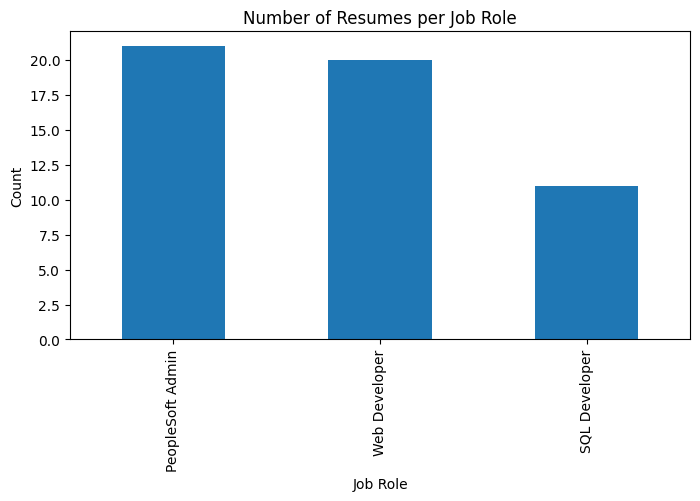

In [ ]:
import matplotlib.pyplot as plt

df['Role'].value_counts().plot(kind='bar', figsize=(8,4))
plt.title("Number of Resumes per Job Role")
plt.ylabel("Count")
plt.xlabel("Job Role")
plt.show()

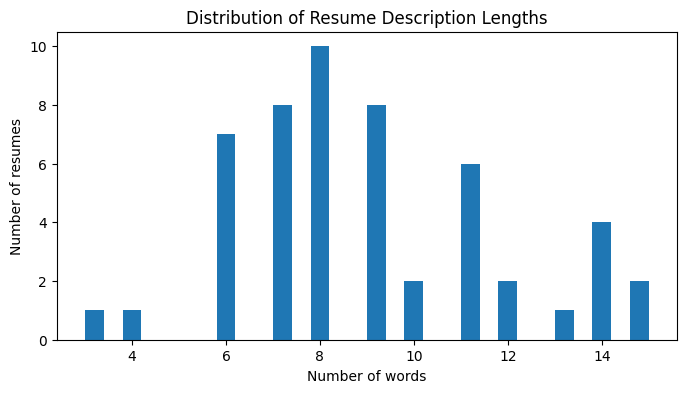

In [ ]:
df['desc_len'] = df['Description'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,4))
plt.hist(df['desc_len'], bins=30)
plt.title("Distribution of Resume Description Lengths")
plt.xlabel("Number of words")
plt.ylabel("Number of resumes")
plt.show()

<Figure size 800x400 with 0 Axes>

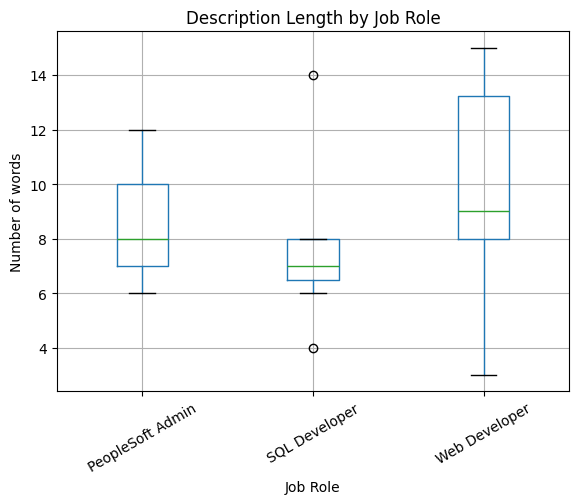

In [ ]:
plt.figure(figsize=(8,4))
df.boxplot(column='desc_len', by='Role')
plt.title("Description Length by Job Role")
plt.suptitle("")
plt.xlabel("Job Role")
plt.ylabel("Number of words")
plt.xticks(rotation=30)
plt.show()

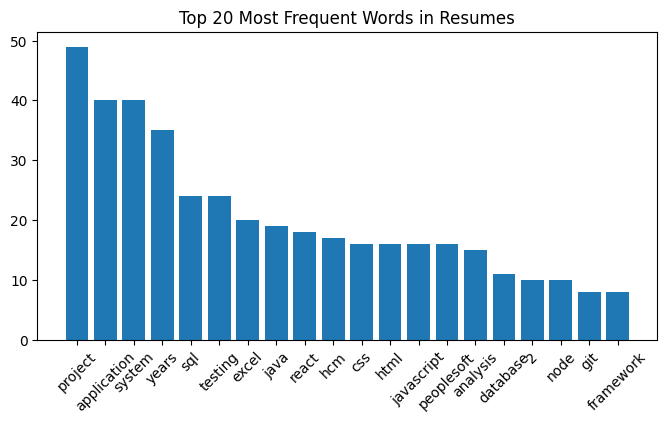

In [ ]:
from collections import Counter

words = " ".join(df['Description']).split()
top_words = Counter(words).most_common(20)

labels, counts = zip(*top_words)

plt.figure(figsize=(8,4))
plt.bar(labels, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words in Resumes")
plt.show()

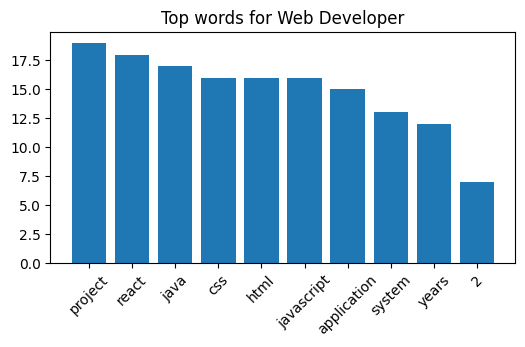

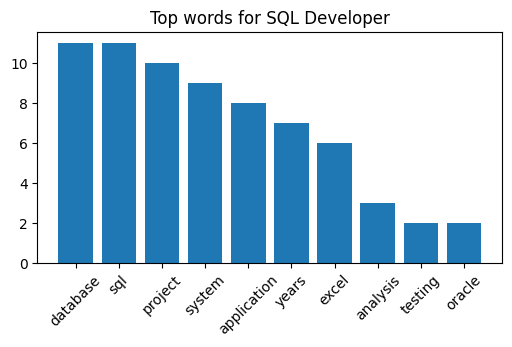

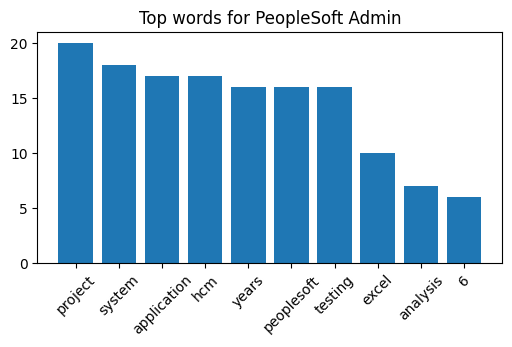

In [ ]:
for role in df['Role'].unique():
    words = " ".join(df[df['Role']==role]['Description']).split()
    top = Counter(words).most_common(10)

    labels, counts = zip(*top)
    plt.figure(figsize=(6,3))
    plt.bar(labels, counts)
    plt.xticks(rotation=45)
    plt.title(f"Top words for {role}")
    plt.show()

In [ ]:
df['desc_len'] = df['Description'].apply(lambda x: len(str(x).split()))

df['desc_len'].describe()

,desc_len
count,52.000000
mean,8.961538
std,2.793280
min,3.000000
25%,7.000000
50%,8.000000
75%,11.000000
max,15.000000


In [ ]:
df[df['desc_len'] < 5][['Name','Role','Description']]

,Name,Role,Description
12,Ravali,Web Developer,java system testing
28,Vinod B,SQL Developer,database excel project sql


In [ ]:
df.groupby("Role")["desc_len"].mean()

,desc_len
Role,
PeopleSoft Admin,8.714286
SQL Developer,7.545455
Web Developer,10.000000


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Description'])

len(vectorizer.get_feature_names_out())

29

In [ ]:
import pandas as pd

words = " ".join(df['Description']).split()
pd.Series(words).value_counts().head(20)

,count
project,49
system,40
application,40
years,35
testing,24
sql,24
excel,20
java,19
react,18
hcm,17


In [ ]:
for role in df['Role'].unique():
    print("\n", role)
    words = " ".join(df[df['Role']==role]['Description']).split()
    print(pd.Series(words).value_counts().head(10))


 Web Developer
project        19
react          18
java           17
javascript     16
html           16
css            16
application    15
system         13
years          12
2               7
Name: count, dtype: int64

 SQL Developer
database       11
sql            11
project        10
system          9
application     8
years           7
excel           6
analysis        3
python          2
oracle          2
Name: count, dtype: int64

 PeopleSoft Admin
project        20
system         18
hcm            17
application    17
peoplesoft     16
testing        16
years          16
excel          10
analysis        7
6               6
Name: count, dtype: int64


Define X and y

In [ ]:
X = df["Description"]   # resume text
y = df["Role"]          # target label





# **Train–Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# **TF-IDF Vectorization**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=5000
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)


#  Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred_lr = lr_model.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 1.0
                  precision    recall  f1-score   support

PeopleSoft Admin       1.00      1.00      1.00         5
   SQL Developer       1.00      1.00      1.00         2
   Web Developer       1.00      1.00      1.00         4

        accuracy                           1.00        11
       macro avg       1.00      1.00      1.00        11
    weighted avg       1.00      1.00      1.00        11



# **Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)




MultinomialNB()

In [ ]:

y_pred_nb = nb_model.predict(X_test_tfidf)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 1.0
                  precision    recall  f1-score   support

PeopleSoft Admin       1.00      1.00      1.00         5
   SQL Developer       1.00      1.00      1.00         2
   Web Developer       1.00      1.00      1.00         4

        accuracy                           1.00        11
       macro avg       1.00      1.00      1.00        11
    weighted avg       1.00      1.00      1.00        11



# **SVM**

In [ ]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

LinearSVC()

In [ ]:
y_pred_svm = svm_model.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.9090909090909091
                  precision    recall  f1-score   support

PeopleSoft Admin       1.00      1.00      1.00         5
   SQL Developer       0.67      1.00      0.80         2
   Web Developer       1.00      0.75      0.86         4

        accuracy                           0.91        11
       macro avg       0.89      0.92      0.89        11
    weighted avg       0.94      0.91      0.91        11



# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
y_pred_rf = rf_model.predict(X_test_tfidf)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8181818181818182
                  precision    recall  f1-score   support

PeopleSoft Admin       0.83      1.00      0.91         5
   SQL Developer       0.67      1.00      0.80         2
   Web Developer       1.00      0.50      0.67         4

        accuracy                           0.82        11
       macro avg       0.83      0.83      0.79        11
    weighted avg       0.86      0.82      0.80        11



# **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_tfidf, y_train)



DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred_dt = dt_model.predict(X_test_tfidf)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 0.7272727272727273
                  precision    recall  f1-score   support

PeopleSoft Admin       0.62      1.00      0.77         5
   SQL Developer       1.00      1.00      1.00         2
   Web Developer       1.00      0.25      0.40         4

        accuracy                           0.73        11
       macro avg       0.88      0.75      0.72        11
    weighted avg       0.83      0.73      0.68        11



# **K-Nearest Neighbors (KNN)**

In [ ]:



from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_tfidf, y_train)


KNeighborsClassifier()

In [ ]:
y_pred_knn = knn_model.predict(X_test_tfidf)

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


KNN Accuracy: 0.9090909090909091
                  precision    recall  f1-score   support

PeopleSoft Admin       1.00      1.00      1.00         5
   SQL Developer       0.67      1.00      0.80         2
   Web Developer       1.00      0.75      0.86         4

        accuracy                           0.91        11
       macro avg       0.89      0.92      0.89        11
    weighted avg       0.94      0.91      0.91        11



# **Model Comparison**

In [ ]:
import pandas as pd
results = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Naive Bayes",
        "SVM",
        "Decision Tree",
        "Random Forest",
        "KNN",
    ],
    "Accuracy": [
        accuracy_score(y_test, lr_model.predict(X_test_tfidf)),
        accuracy_score(y_test, nb_model.predict(X_test_tfidf)),
        accuracy_score(y_test, svm_model.predict(X_test_tfidf)),
        accuracy_score(y_test, dt_model.predict(X_test_tfidf)),
        accuracy_score(y_test, rf_model.predict(X_test_tfidf)),
        accuracy_score(y_test, knn_model.predict(X_test_tfidf))
    ]
})

results


,Model,Accuracy
0,Logistic Regression,1.000000
1,Naive Bayes,1.000000
2,SVM,0.909091
3,Decision Tree,0.727273
4,Random Forest,0.818182
5,KNN,0.909091
